In [16]:
import numpy as np
from common.methods import softmax, cross_entropy_error, numerical_gradient
from collections import OrderedDict
import matplotlib.pyplot as plt

from dataset.mnist import load_mnist

# Basic Concept

## Multiply Layer

In [2]:
class MultiplyLayer:
    def __init__(self):
        self.x = 0.0
        self.y = 0.0
        
    def forward(self, x, y):
        self.x = x
        self.y = y
        return self.x * self.y
    
    def backward(self, dout):
        # dout is the differentiation value from the upper layer
        dx = dout * self.y
        dy = dout * self.x
        return dx, dy

### forward propagation

In [3]:
fruit = 100
fruit_num = 2
tax = 1.1

# layer
mul_fruit_layer = MultiplyLayer()
mul_tax_layer = MultiplyLayer()

# forward
fruit_price = mul_fruit_layer.forward(fruit, fruit_num)
price = mul_tax_layer.forward(fruit_price, tax)

print(price)

220.00000000000003


### backward propagation

In [4]:
dprice = 1
dfruit_price, dtax = mul_tax_layer.backward(dprice)
dfruit, dfruit_num = mul_fruit_layer.backward(dfruit_price)
print(dfruit, dfruit_num, dtax)

2.2 110.00000000000001 200


## Add Layer

In [5]:
class AddLayer:
    def __init__(self):
        self.x = 0.0
        self.y = 0.0
    
    def forward(self, x, y):
        self.x = x
        self.y = y
        return self.x + self.y
    
    def backward(self, dout):
        dx = dout * 1
        dy = dout * 1
        return dx, dy

## Combine MultiplyLayer and AddLayer

In [6]:
apple_price = 100
apple_num = 2
orange_price = 150
orange_num = 3
tax = 1.1

# layer
mul_apple_layer = MultiplyLayer()
mul_orange_layer = MultiplyLayer()
add_apple_orange_layer = AddLayer()
mul_tax_layer = MultiplyLayer()

# forward
apple = mul_apple_layer.forward(apple_price, apple_num)
orange = mul_orange_layer.forward(orange_price, orange_num)
fruit_sum = add_apple_orange_layer.forward(apple, orange)
price = mul_tax_layer.forward(fruit_sum, tax)
print("Total Price:", price)

# backward
dprice = 1
dfruit_sum, dtax = mul_tax_layer.backward(dprice)
dapple, dorange = add_apple_orange_layer.backward(dfruit_sum)
dapple_price, dapple_num = mul_apple_layer.backward(dapple)
dorange_price, dorange_num = mul_orange_layer.backward(dorange)
print("dapple_price:", dapple_price)
print("dapple_num:", dapple_num)
print("dorange_price:", dorange_price)
print("dorange_num:", dorange_num)
print("dtax:", dtax)

Total Price: 715.0000000000001
dapple_price: 2.2
dapple_num: 110.00000000000001
dorange_price: 3.3000000000000003
dorange_num: 165.0
dtax: 650


# Relu and Sigmoid

In [7]:
class Relu:
    def __init__(self):
        self.mask = None
        
    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        return out
    
    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        return dx
    
class Sigmoid:
    def __init__(self):
        self.out = None
        
    def forward(self, x):
        self.out = 1 / (1 + np.exp(-x))
        return self.out
    
    def backward(self, dout):
        dx = dout * self.out * (1.0 - self.out)
        return dx

# Affline and Softmax

In [8]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None
    
    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b
        return out
    
    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis = 0)
        
        return dx

In [9]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None
        
    def forward(self, y, t):
        self.y = softmax(y)
        self.t = t
        self.loss = cross_entropy_error(self.y, t)
        
        return self.loss
    
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size
        return dx

# Build a Two Layer Net on Backpropagation

In [10]:
class AdvTwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=1e-2):
        # wights and biases
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        
        # layers
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.lastLayer = SoftmaxWithLoss()
    
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    
    def loss(self, x, t):
        # x: input data
        # t: labeling
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1: t = np.argmax(t, axis=1)
        acc = np.sum(y == t) / float(t.shape[0])
        return acc
    
    def numerical_gradient(self, x, t):
        loss_w = lambda w: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_w, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_w, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_w, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_w, self.params['b2'])
        return grads
    
    def gradient(self, x, t):
        # forward
        self.loss(x, t)
        
        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
        
        # set gradient
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db
        
        return grads

# Rewrite the function

Due to batch data, we have to rewite several functions, including softmax and cross_entropy_error defined in common.methods.

```python
def softmax(x):
    # we have adjusted this function to meet batch data
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T
    else:
        x = x - np.max(x)
        return np.exp(x) / np.sum(np.exp(x))

def cross_entropy_error(y, t):
    # we have adjusted this function to meet batch data
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size
```

# gradient check

In [11]:
# input data
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

# create a two layer neural network
advTwoLayNet = AdvTwoLayerNet(input_size=784, hidden_size=50, output_size=10)

x_batch = x_train[:3]
t_batch = t_train[:3]

# numerical gradient
grad_numerical = advTwoLayNet.numerical_gradient(x_batch, t_batch)

# backpropagation
grad_propagation = advTwoLayNet.gradient(x_batch, t_batch)

# calculate the average error
for key in grad_numerical.keys():
    diff = np.average(np.abs(grad_propagation[key] - grad_numerical[key]))
    print(key + " : " + str(diff))

W1 : 3.774872414120354e-10
b1 : 2.295691687141405e-09
W2 : 5.043069437300973e-09
b2 : 1.4044494027476428e-07


# Learning on Backpropagation

In [14]:
# input data
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

# create a two layer neural network
advTwoLayNet = AdvTwoLayerNet(input_size=784, hidden_size=50, output_size=10)

# parameters
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 1e-1

# history
train_loss_list = []
train_acc_list = []
test_acc_list = []
iter_per_epoch = max(x_train.shape[0] / batch_size, 1)

# start learning
for i in range(iters_num):
    #if i % batch_size == 0: print("Iter:", str(i))
    
    # get batch data
    batch_index = np.random.choice(train_size, batch_size)
    batch_data = x_train[batch_index]
    batch_label = t_train[batch_index]
    
    # calculate the gradient
    grad = advTwoLayNet.gradient(batch_data, batch_label)
    
    # update the weights and biases
    for key in ['W1', 'b1', 'W2', 'b2']:
        advTwoLayNet.params[key] -= learning_rate * grad[key]
    
    # calculate loss and record it
    loss = advTwoLayNet.loss(batch_data, batch_label)
    train_loss_list.append(loss)
    
    # epoch
    if i % iter_per_epoch == 0:
        train_acc_res = advTwoLayNet.accuracy(x_train, t_train)
        test_acc_res = advTwoLayNet.accuracy(x_test, t_test)
        train_acc_list.append(train_acc_res)
        test_acc_list.append(test_acc_res)
        print(train_acc_res, test_acc_res)

0.08491666666666667 0.083
0.9022 0.9041
0.9243833333333333 0.9253
0.9360166666666667 0.9341
0.9453333333333334 0.9427
0.94935 0.9464
0.9547166666666667 0.9511
0.9596833333333333 0.9553
0.96245 0.9586
0.966 0.9612
0.96715 0.9618
0.9690333333333333 0.9628
0.9721666666666666 0.9661
0.9739333333333333 0.9678
0.9756833333333333 0.9659
0.9768166666666667 0.9677
0.9778333333333333 0.9667


## show training history

### Accuracy

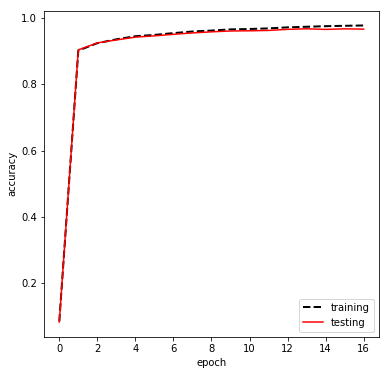

In [28]:
fig = plt.figure()
plt.plot(train_acc_list, linestyle="--", label="training", color="black", linewidth=2)
plt.plot(test_acc_list, linestyle="-", label="testing", color="red")
plt.xlabel("epoch")
plt.ylabel("accuracy")
fig.set_figwidth(6)
fig.set_figheight(6)
plt.legend()
plt.show()

### Loss

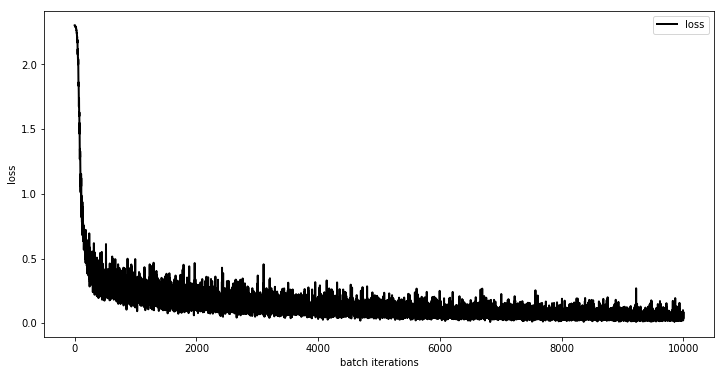

In [29]:
fig = plt.figure()
plt.plot(train_loss_list, linestyle="-", label="loss", color="black", linewidth=2)
plt.xlabel("batch iterations")
plt.ylabel("loss")
fig.set_figwidth(12)
fig.set_figheight(6)
plt.legend()
plt.show()